# Test Spot2vector on the breast cancer 10X Visium data

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

## Import data

In [2]:
data_name = 'BreastCancer'

In [3]:
n_clusters = 20

In [4]:
adatast = sc.read_h5ad('./data/BreastCancer/preprocess_' +  data_name + '.h5ad')

In [5]:
adatast

AnnData object with n_obs × n_vars = 3798 × 8000
    obs: 'in_tissue', 'array_row', 'array_col', 'cluster', 'domain_annotation', 'Ground Truth', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Ground Truth_colors', 'hvg', 'log1p', 'spatial'
    obsm: 'spatial'

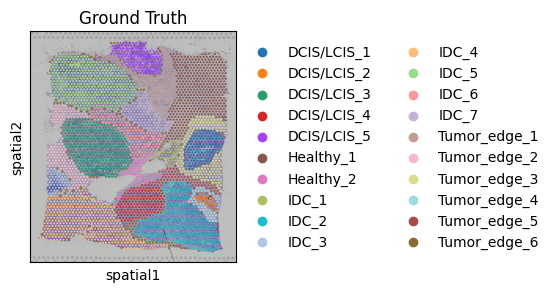

In [6]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adatast, img_key="hires", 
              color="domain_annotation", 
              title="Ground Truth")

In [7]:
sc.pp.pca(adatast, n_comps=10)

## Run Spot2Vector

In [8]:
import Spot2Vector

Spot2Vector.Build_Graph(adatast, radius_cutoff=300, cutoff_type='radius', graph_type='spatial')
Spot2Vector.Build_Graph(adatast, neighbors_cutoff=6, cutoff_type='neighbors', graph_type='expression')

The spatial KNN grpah contains 3798 nodes and 22064.0 edges.(except self-loop)
Average degree of spatial graph: 5.81.
The expression KNN grpah contains 3798 nodes and 22788.0 edges.(except self-loop)
Average degree of expression graph: 6.00.


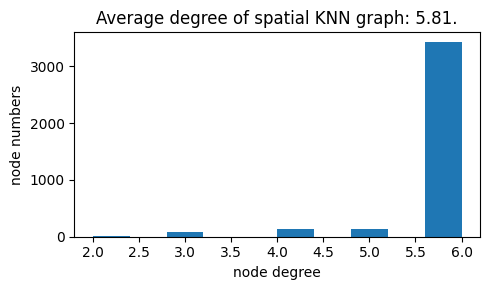

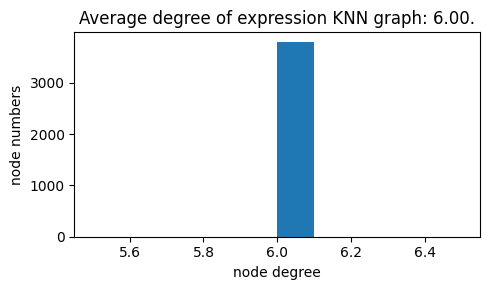

In [9]:
Spot2Vector.Graph_Stat_Plot(adatast)

In [10]:
device = 'cuda:1'
Spot2Vector.Fit(adatast, verbose=False, seed=1, device=device, max_epochs_st=1000)

Training: 100%|██████████| 1000/1000 [04:53<00:00,  3.41epoch/s, epoch=999, loss=0.627, lr=0.0001]


<Axes: xlabel='epoch', ylabel='loss_total'>

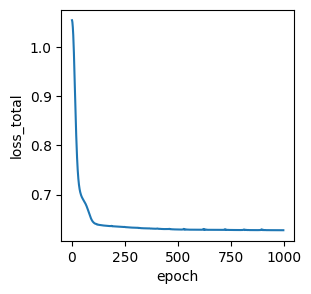

In [11]:
sns.lineplot(adatast.uns['training_history_df_st'], x = 'epoch', y='loss_total')

## Clustering

In [12]:
clust_method = 'mclust'

In [13]:
Spot2Vector.Clustering(adatast, obsm_data='exp_embeddings', method=clust_method, n_cluster=n_clusters, verbose=False)
Spot2Vector.Clustering(adatast, obsm_data='spa_embeddings', method=clust_method, n_cluster=n_clusters, verbose=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


In [16]:
# lamda = 1 for expression, lamda = 0 for spatial
Spot2Vector.Infer(adatast, lamda=0.2, device=device)

In [17]:
Spot2Vector.Clustering(adatast, obsm_data='embeddings', method=clust_method, n_cluster=n_clusters, verbose=False)

fitting ...
  |======================================================================| 100%


In [18]:
Spot2Vector.Clustering_Metrics(adatast, f'embeddings_{clust_method}')

ARI of embeddings_mclust is: 0.6711581438379288
NMI of embeddings_mclust is: 0.7108302925386721


## Visualization

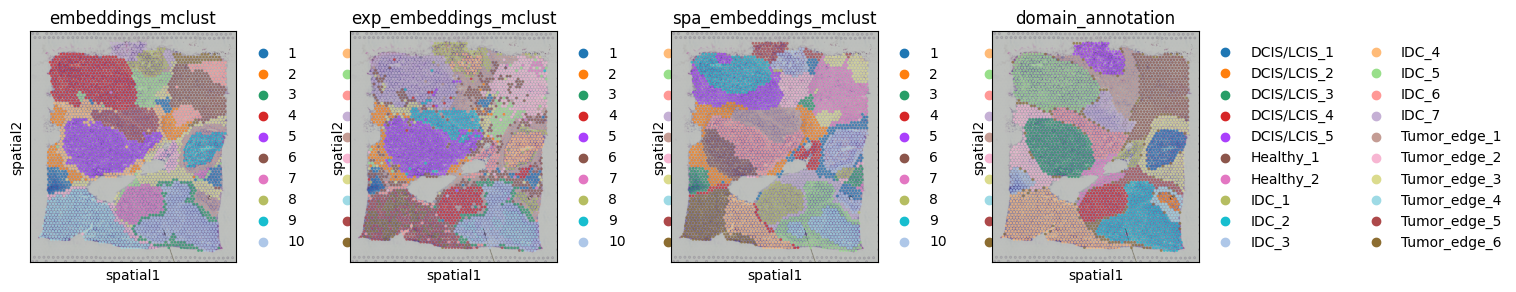

In [19]:
sc.pl.spatial(adatast,
              color=[f"embeddings_{clust_method}",
                     f"exp_embeddings_{clust_method}", 
                     f"spa_embeddings_{clust_method}", 
                     "domain_annotation"], 
              title=[f"embeddings_{clust_method}",
                     f"exp_embeddings_{clust_method}", 
                     f"spa_embeddings_{clust_method}", 
                     "domain_annotation"], 
              size=1.3, 
              alpha=0.7)

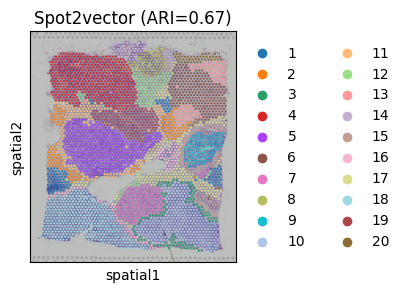

In [20]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adatast, color=f"embeddings_{clust_method}", 
              title='Spot2vector (ARI=' + str(np.round(adatast.uns['embeddings_mclust_ARI'], 2)) + ')', 
              save=data_name + '_Spot2vector.svg')